In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rc

SUBSET_LEN = 11
SHIFT_RECORDS = 16 # конец выборки + 6
storm_wind_speed = 10 # [10 / 1.5, 10, 10 * 1.5]
DPI = 80
FIGSIZE, FIGSIZE_LONG = (10, 6), (12, 6)

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex',preamble='\\usepackage[utf8]{inputenc}')
rc('text.latex',preamble='\\usepackage{amsfonts}')
rc('text.latex',preamble='\\usepackage{amssymb}')
rc('text.latex',preamble='\\usepackage[russian]{babel}')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('legend', fontsize=20)
rc('axes', labelsize=20)

In [2]:
wind_df = pd.read_csv("wind.csv", index_col=0)
sea_df = pd.read_csv("sla.csv", index_col=0)

In [3]:
coordinates = wind_df.index
dates = wind_df.columns

Для трех значений параметра $v_{border}$ — минимальной скорости штормового ветра — рассмотрим разницу между средними значениями аномалий уровня моря и скорости ветра в заданных точках.

In [4]:
storms = []
storms_file = open("storms_{}.txt".format(storm_wind_speed), "w")
for i in range(len(coordinates)):
    index = coordinates[i]
    
    j = 0
    while j + SUBSET_LEN < len(dates):
        if wind_df.iloc[i, j] < storm_wind_speed: # нет шторма
            j += 1
        else: # шторм, смотрим
            count_storm, count_calm = 0, 0
            for shift in range(SUBSET_LEN):
                if not np.isnan(sea_df.iloc[i, j + shift]):
                    count_storm += (wind_df.iloc[i, j + shift] >= storm_wind_speed)
                    count_calm += (wind_df.iloc[i, j + shift] < storm_wind_speed)
            
            if count_storm >= 4 and count_calm >= 4 and count_storm + count_calm == SUBSET_LEN:
                cur_row = [count_storm, count_calm, i, j]
                print(" ".join(map(str, cur_row)), file=storms_file)
                storms.append([count_storm, count_calm, i, j]) # начало шторма
            j += SUBSET_LEN
storms_file.close()
print(len(storms))

458652


In [5]:
N_subsets = len(storms)
source_rows_list = []
for index in range(N_subsets):
    i, j = storms[index][2], storms[index][3]
    count_storm = storms[index][0] # количество штормовых дней
    count_calm = storms[index][1] # количество спокойных дней
    storm_coordinates = wind_df.index[i] # координаты шторма
    storm_date = wind_df.columns[j] # дата начала шторма
    
    storm_sea, calm_sea = [], []
    for shift in range(SUBSET_LEN):
        cur_sla = sea_df.iloc[i, j + shift]
        cur_wind = wind_df.iloc[i, j + shift]
        if cur_wind >= storm_wind_speed:
            storm_sea.append(cur_sla)
        else:
            calm_sea.append(cur_sla)
    
    mean_storm_sla = np.mean(storm_sea)
    mean_calm_sla = np.mean(calm_sea)
    row_df = [storm_date, storm_coordinates, count_storm, count_calm, 
              mean_storm_sla, mean_calm_sla, mean_storm_sla - mean_calm_sla]
    source_rows_list.append(row_df)

source_subsets_df = pd.DataFrame(source_rows_list, 
        columns=["start_date", "coordinates", "count_storm", "count_calm", "sla_storm", "sla_calm", "sla_diff"])
sla_diff = source_subsets_df.sla_diff.to_numpy()

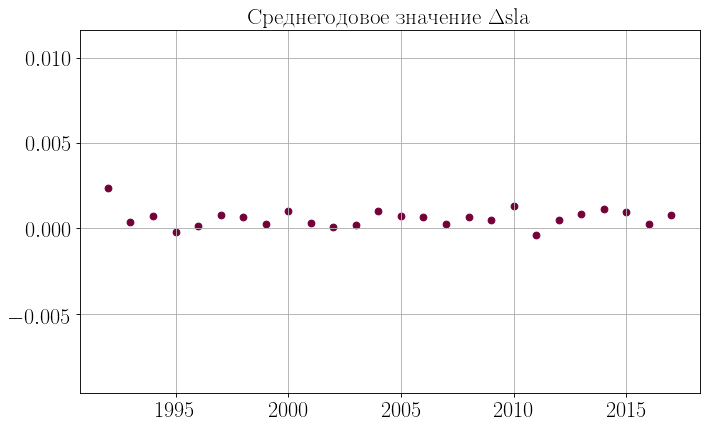

средняя разница: 0.0006186620253916648


In [6]:
source_years = source_subsets_df.apply(lambda x: int(x.start_date[:4]), axis=1)

year_sla_diff = []
start_year = 1992
finish_year = 2018
for cur_year in range(start_year, finish_year):
    cur_year_df = source_subsets_df[source_years == cur_year]
    mean_sla_calm = cur_year_df.sla_calm.mean()
    mean_sla_storm = cur_year_df.sla_storm.mean()
    year_sla_diff.append(mean_sla_storm - mean_sla_calm)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.scatter(np.arange(start_year, finish_year), year_sla_diff, color="xkcd:merlot")
plt.title("Среднегодовое значение $\Delta$sla", fontsize=20)
plt.grid(True)
plt.show()

print("средняя разница:", np.array(year_sla_diff).mean())

0.8886879635714285


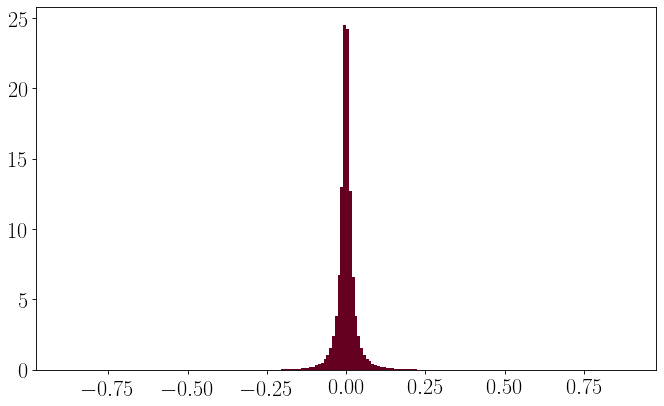

In [7]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
abs_max = abs(sla_diff).max()
print(abs_max)
n_bins = 200
(y, bins, _) = plt.hist(sla_diff, bins=n_bins, density=True, range=(-abs_max, abs_max), color="xkcd:maroon")
x = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])

Распределение полученной величины $X$ вблизи нуля выглядит следующим образом:

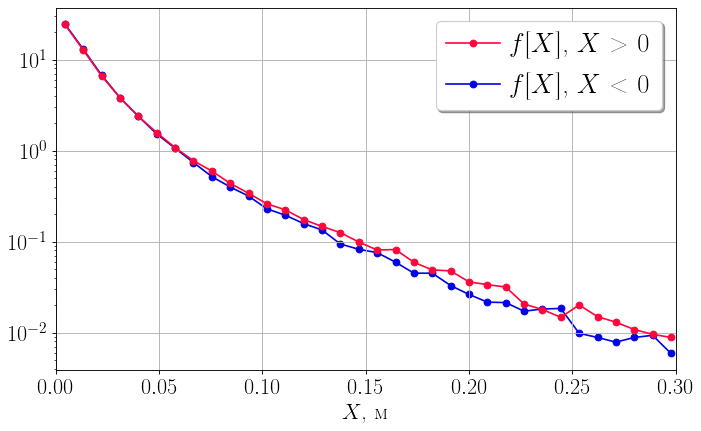

In [8]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.grid(True)
plt.yscale("log")
plt.plot(x[(x >= 0) & (x <= 0.3)], y[(x >= 0) & (x <= 0.3)], "-o", 
         color="xkcd:neon red", label="$f$[$X$], $X$ > 0")
plt.plot(-x[(x <= 0) & (x >= -0.3)], y[(x <= 0) & (x >= -0.3)], "-o", 
         color="xkcd:pure blue", label="$f$[$X$], $X$ < 0", zorder=1)
plt.xlabel("$X$, м")
plt.xlim((0.0, 0.3))
plt.legend(handletextpad=0.4, shadow=0.1, fontsize=24)
plt.show()
fig.savefig("pictures/sla_log_hist_{}.pdf".format(storm_wind_speed), bbox_inches='tight', pad_inches=0)

Данный график свидетельствует о том, что площадь под красной кривой превышает площадь под синей кривой, вследствие чего величина $p(a) = P[X \geq a] - P[X \leq -a]$ оказывается положительной. Её статистическая значимость проверяется тестированием с перемешиванием исходных данных и применением метода Монте-Карло.

In [9]:
random_sla_error_filename = "random_sla_error_{}.txt".format(storm_wind_speed)
random_sla_error_estimate = np.loadtxt(random_sla_error_filename, dtype=float)

In [10]:
mean_columns_error = random_sla_error_estimate.mean(axis=0)

S = []
for i in range(len(random_sla_error_estimate)):
    assert(len(random_sla_error_estimate[i]) == len(mean_columns_error))
    S.append(np.sum((random_sla_error_estimate[i] - mean_columns_error) ** 2))

S_990 = sorted(S)[990]
std = random_sla_error_estimate.std(axis=0)
delta = std / np.sqrt(np.sum(std ** 2)) * np.sqrt(S_990)
assert(abs(sum(delta ** 2) - S_990) < 1e-15)

In [11]:
test_red = y[(x >= 0) & (x <= 0.4)]
test_x_reverse = np.flip(x[(x < 0) & (x >= -0.4)])
test_blue_reverse = np.flip(y[(x < 0) & (x >= -0.4)])

x_hist = x[(x >= 0) & (x <= 0.4)]
y_hist_minus = test_red - test_blue_reverse
y_hist_plus = test_red + test_blue_reverse

estimate_error = []
for i in range(2, len(x_hist) - 2):
    sla_diff_expectation = 0.0
    sla_sum_density = 0.0
    for shift in range(-2, 3):
        sla_diff_expectation += x_hist[i + shift] * y_hist_minus[i + shift]
        sla_sum_density += y_hist_plus[i + shift]
    estimate_error.append(sla_diff_expectation / sla_sum_density)

assert(len(estimate_error) == len(delta))
assert(len(estimate_error) == len(x_hist[2:-2]))

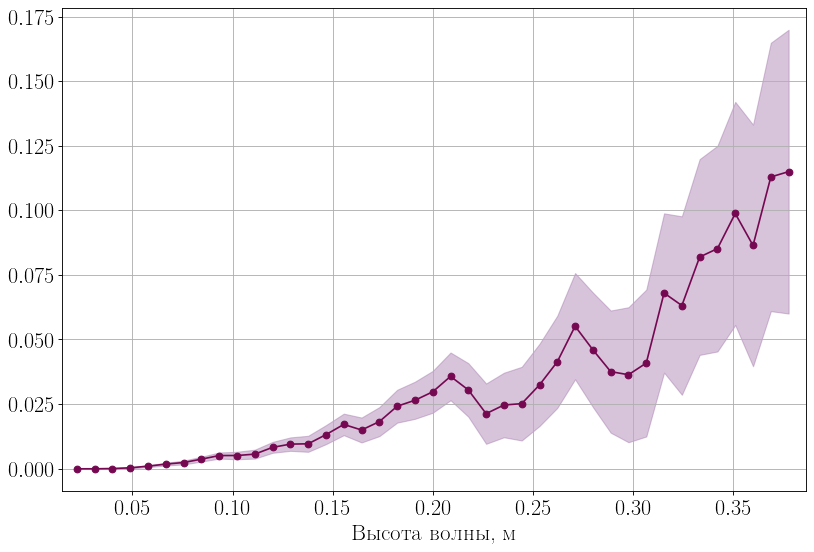

In [21]:
delta_950 = std / np.sqrt(np.sum(std ** 2)) * np.sqrt(sorted(S)[950])

fig = plt.figure(dpi=80, figsize=(12, 8))
plt.grid(True)
plt.plot(x_hist[2:-2], estimate_error, "-o", color="xkcd:velvet")
plt.fill_between(x_hist[2:-2], estimate_error + delta_950, estimate_error - delta_950, 
                 color="xkcd:dark lilac", alpha=0.4)
plt.xlim((0.015, x_hist[-2]))
plt.xlabel("Высота волны, м")
plt.show()
fig.savefig("pictures/error_estimate_{}.pdf".format(storm_wind_speed), bbox_inches='tight', pad_inches=0)

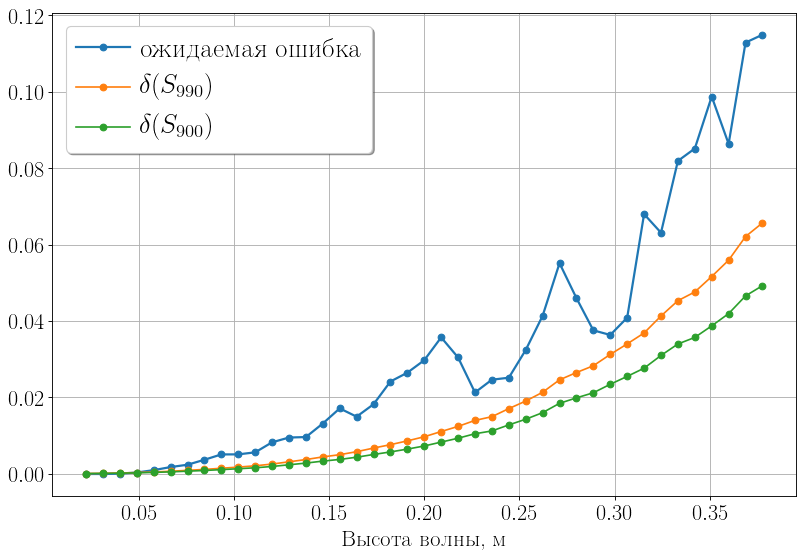

In [13]:
delta_990 = std / np.sqrt(np.sum(std ** 2)) * np.sqrt(sorted(S)[990])
delta_900 = std / np.sqrt(np.sum(std ** 2)) * np.sqrt(sorted(S)[900])

fig = plt.figure(dpi=80, figsize=(12, 8))
plt.grid(True)
plt.plot(x_hist[2:-2], estimate_error, '-o', label="ожидаемая ошибка", lw=2)
plt.plot(x_hist[2:-2], delta_990, '-o', label=r'$\delta(S_{990})$')
plt.plot(x_hist[2:-2], delta_900, '-o', label=r'$\delta(S_{900})$')
plt.xlabel("Высота волны, м")

plt.legend(fontsize=24, handletextpad=0.4, shadow=0.1)
plt.show()
fig.savefig("pictures/error_delta_{}.pdf".format(storm_wind_speed), bbox_inches='tight', pad_inches=0)

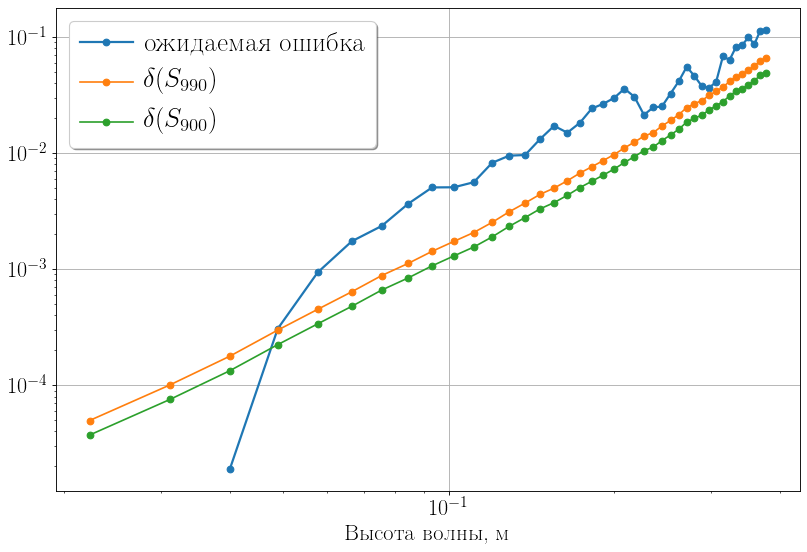

In [14]:
fig = plt.figure(dpi=80, figsize=(12, 8))
plt.grid(True)
x_hist = np.array(x_hist)
estimate_error = np.array(estimate_error)
plt.plot(x_hist[2:-2][estimate_error > 0], estimate_error[estimate_error > 0], '-o', 
         label="ожидаемая ошибка", lw=2)
plt.plot(x_hist[2:-2], delta_990, '-o', label=r'$\delta(S_{990})$')
plt.plot(x_hist[2:-2], delta_900, '-o', label=r'$\delta(S_{900})$')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Высота волны, м")
plt.legend(fontsize=24, handletextpad=0.4, shadow=0.1)
plt.show()
fig.savefig("pictures/modified_pictures_{}_log.png".format(storm_wind_speed), bbox_inches='tight', pad_inches=0)

Полученные значения ожидаемой ошибки превышают вероятный разброс значений, что подтверждает статистическую значимость найденного эффекта.

In [15]:
tests_number = 1000

x_min = dict({6.7: 0.05, 10: 0.015, 15: 0.0}) # [start_a, 0.5] с шагом 0.005
a = np.arange(x_min[storm_wind_speed], 0.5001, 0.005)
y_min = dict({6.7: 1e-5, 10: 1e-5, 15: 1e-4})
y_max = dict({6.7: 1e-3, 10: 1e-2, 15: 10**(-1.5)})
x_max = dict({6.7: 0.42, 10: 0.5, 15: 0.5})

def getProbabilityDifference(values, a_array): # P[X >= a] - P[X <= -a]
    return np.array([((values >= a).sum() - (values <= -a).sum()) / values.size for a in a_array])

In [16]:
random_expectations_filename = "random_exp_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS)
random_expectations = np.loadtxt(random_expectations_filename, dtype=float)
assert(random_expectations.shape == (tests_number,))

In [17]:
random_proba_filename = "random_proba_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS)
random_proba_difference = np.loadtxt(random_proba_filename, dtype=float)
assert(random_proba_difference.shape == (tests_number, len(a)))

In [18]:
need_percentile = 99
need_index = 990
random_proba_endvalues = [np.percentile(random_proba_difference[:,i], need_percentile) for i in range(len(a))]
real_proba_difference = getProbabilityDifference(sla_diff, a)
test_number = np.where(random_expectations == sorted(random_expectations)[need_index])[0][0]

In [19]:
picture_file = open("graph_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS), "w")
print(" ".join(map(str, real_proba_difference)), file=picture_file)
print(" ".join(map(str, random_proba_endvalues)), file=picture_file)
print(" ".join(map(str, random_proba_difference[test_number])), file=picture_file)
picture_file.close()

speed = 6.7


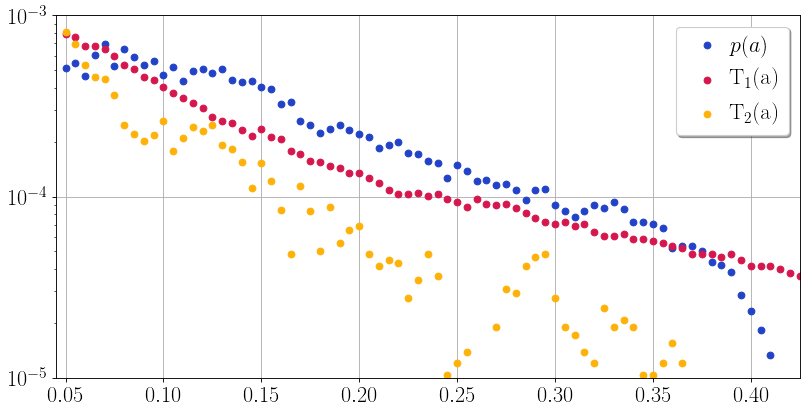

speed = 10


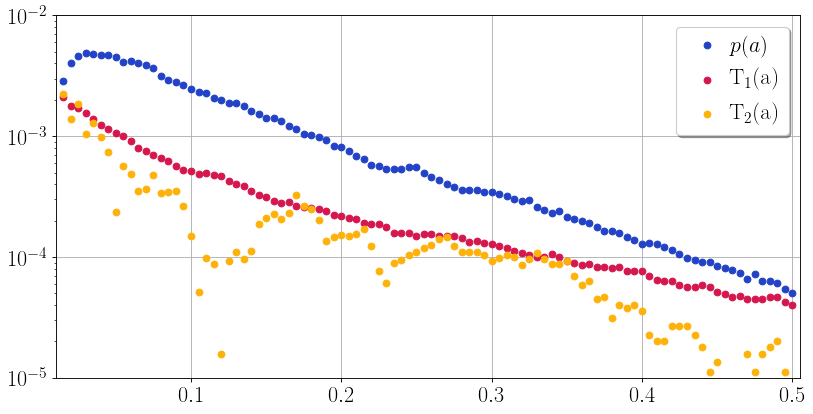

speed = 15


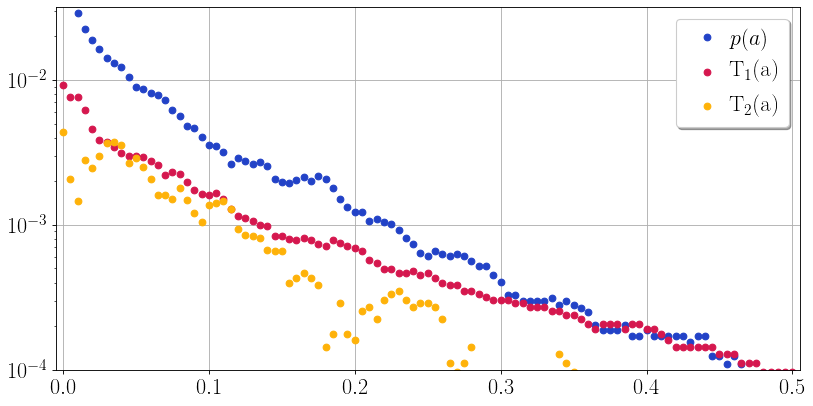

In [20]:
for storm_wind in [6.7, 10, 15]:
    print("speed =", storm_wind)
    a = np.arange(x_min[storm_wind], 0.5001, 0.005)

    picture_file = open("graph_{}_{}.txt".format(storm_wind, SHIFT_RECORDS), "r")
    first_line = list(map(float, picture_file.readline().split()))
    assert(len(first_line) == len(a))
    second_line = list(map(float, picture_file.readline().split()))
    assert(len(second_line) == len(a))
    third_line = list(map(float, picture_file.readline().split()))
    assert(len(third_line) == len(a))
    picture_file.close()

    fig = plt.figure(dpi=DPI, figsize=FIGSIZE_LONG)
    plt.plot(a, first_line, "o", color="xkcd:blue blue", label="$p(a)$")
    plt.plot(a, second_line, "o", color="xkcd:lipstick", label="T$_1$(a)")
    plt.plot(a, third_line, "o", color="xkcd:saffron", label="T$_2$(a)")
    plt.ylim(y_min[storm_wind], y_max[storm_wind])
    plt.xlim(x_min[storm_wind] - 0.005, x_max[storm_wind] + 0.005)
    plt.grid(True)
    plt.yscale("log")
    plt.legend(handletextpad=0.0, shadow=0.1)
    plt.show()
    fig.savefig("pictures/random_tests_log_{}.pdf".format(storm_wind), bbox_inches='tight', pad_inches=0)

Таким образом, реальные наблюдаемые значения оказываются заметно больше даже крайних значений, полученных в результате статистического тестирования. Следовательно, можно говорить о статистической значимости найденного эффекта.